# Filtering and Resampling

Filtering seismic data alows us to increase the signal-to-noise ratio of specific frequency ranges that we are interested in.  
Remember that (from Stein and Wysession Figure 2.4-7) the range of frequencies for different types of seismic waves cover a wide
spectrum, with:
- reflection seismology often interested in signals in the 10Hz-1kHz range,
- earthquake seismology usually concerned with data in the 0.01-50Hz range and
- studies of normal modes thinking about frequencies in the 0.00001-0.01Hz range.
Surface waves also have different frequency content to body waves.  Because of this, we can filter the same data in different
*pass-bands* to look at different features of the seismogram. A nice example of this is the seismogram of the Kaikoura 2016
M7.8 earthquake, recording on White Island. While the Kaikoura earthquake was happening, the aftershock sequence of the Te
Araroa M7.2 earthquake was going on (see [Warren-Smith et al., 2018](https://www.sciencedirect.com/science/article/pii/S0012821X17306568)
for more details). By filtering in different passbands we
can see the surface waves from Kaikoura as well as the more local seismicity, which has a higher frequency content.

In [1]:
# Set up notebook
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from obspy import read, UTCDateTime
from obspy.clients.fdsn import Client
from scipy import signal, fftpack
plt.style.use('ggplot') # Makes plots work well with dark theme

Lets download some data from GeoNet for the [WIZ station](https://www.geonet.org.nz/data/network/sensor/WIZ), which is a 
broadband sensor on the White Island volcano.
We will get data from the Kaikoura origin-time to quarter of an hour later.

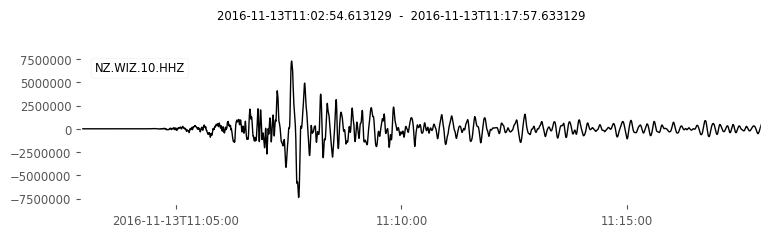

In [2]:
client = Client("GEONET")
kaikoura_origin_time = UTCDateTime(2016, 11, 13, 11, 2, 56)
st = client.get_waveforms(
    network="NZ", station="WIZ", channel="HHZ", location="10", 
    starttime=kaikoura_origin_time, endtime=kaikoura_origin_time + (15 * 60))
fig = st.plot()

We can see the initial high-frequency body waves followed by strong low-frequency energy of the surface waves. 
You will also note that it takes a reasonable time for the first arriving seismic energy to reach this far from the earthquake.

We can visualise the frequencies nicely by looking at a spectrogram.  The spectrogram computes the frequency content
in moving windows along the trace and plots the normalised power of those frequencies as different colours. In the spectrogram
below you can clearly see the dominant low-frequency energy.

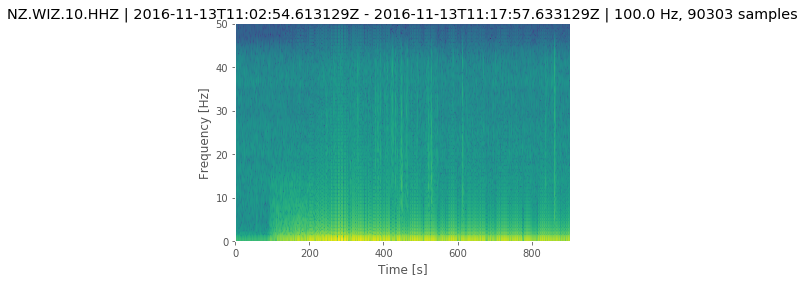

In [3]:
fig = st[0].spectrogram(dbscale=True)

Lets try and looks at just the high-frequencies.  Obspy has a convenient *filter* method on Stream and Trace objects.  We will use that before digging in to how
filtering works.

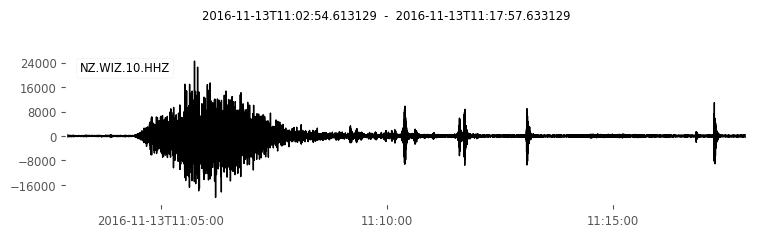

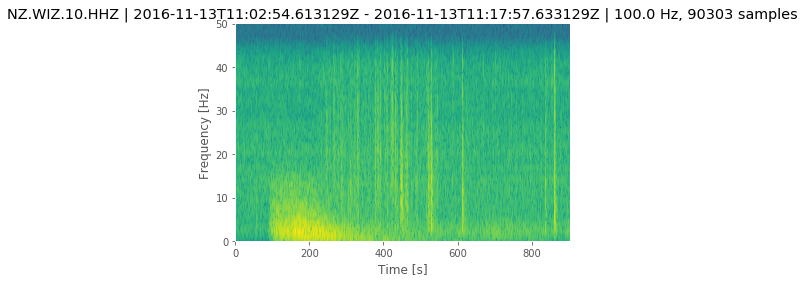

In [4]:
st_highpass = st.copy().filter("highpass", freq=2.)
fig = st_highpass.plot()
fig = st_highpass.spectrogram(dbscale=True)

We can see a lot of emmergent high-frequency energy associated with body waves from the Kaikoura earthquake itself in the 
beginning of this wave-train. However, the later bursts of energy are likely a more local source. We couldn't see those in
the original, broadband waveform. Lets have a look at one of those more local events.

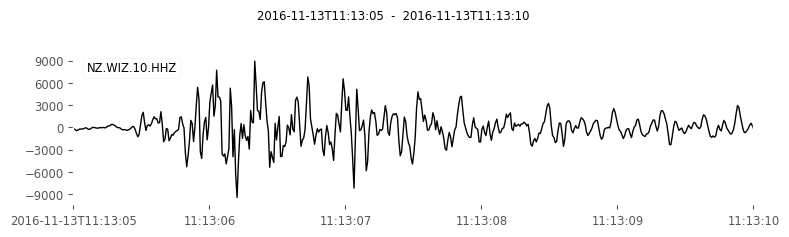

In [5]:
fig = st_highpass.plot(
    starttime=UTCDateTime(2016, 11, 13, 11, 13, 5),
    endtime=UTCDateTime(2016, 11, 13, 11, 13, 10))

This is likely to be an aftershock of the Te Araroa sequence - there is dominant high-frequency energy. 
Unfortunately, stations closer to the Te Araroa epicenter have clipped waveforms - the signal from Kaikoura
exceeded the dynamic range of the sensor, which makes filter operations unstable.

Now lets try and just look at the low-frequency energy.

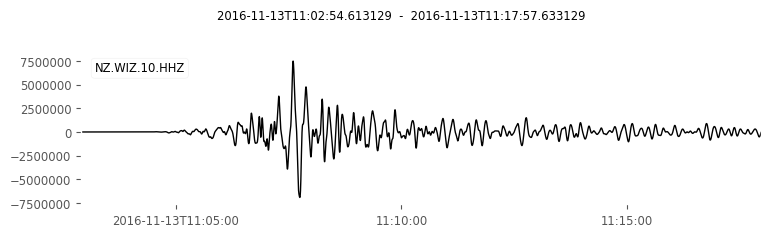

In [6]:
st_lowpass = st.copy().filter("lowpass", freq=.25)
fig = st_lowpass.plot()

Now that we know that filters can be useful for various things, including separating energy from different sources, lets think about how filters work.

## How filters work

Filters work to remove energy at certain frequencies. This involves convolving some filter series with your data. In the time domain, convolution can be
a slow process, however, in the frequency domain, convolutions are simple multiplications. Because multiplication is a less computationally
expensive operation than convolution, filtering is often undertaken in the frequency domain.

In the next section we will think about some basic linear filters and look at different bandpass types, different filter window types, and
play with the order of the filters and the frequency ranges used.

First we will set up a few functions that:
1. Design a filter in the frequency domain using scipy's 
   [iirfilter](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.iirfilter.html#scipy.signal.iirfilter) function.
2. Apply the filter and plot the results in the time and frequency domains.

It is worth noting that these filters only work for fairly simple filters, and in more general cases the use of
[second-order sections](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.sosfilt.html#scipy.signal.sosfilt)
is recommended.  Obspy uses this internally when you use the *filter* method.

In [7]:
def design_filter(sample_rate, data_length, corners, order=4, window_type='butter',
                  filter_type='bandpass', ripple=None, attenuation=None):
    """
    Design a frequency-domain filter.
    
    :type sample_rate: float
    :param sample_rate: Sampling-rate in Hz
    :type data_length: int
    :param data_length: 
        Length of data to apply to - will use the next-fast fft length from this.
    :type corners: array-like
    :param corners: list of corners for filter in order, in Hz
    :type order: int
    :param order: Filter order
    :type window_type: str
    :param window_type: 
        Type of window to use, must be one of:
        'butter' : Butterworth
        'cheby1': Chebyshev I
        'cheby2': Chenyshev II
        'ellip': Cauer/elliptic
        'bessel': Bessel/Thomson
    :type filter_type: str
    :param filter_type: 
        Type of band to use, must be one of: 
        'bandpass', 'lowpass', 'highpass', 'bandstop'
    """
    nyquist = .5 * sample_rate
    # Check that highpass is usefully less than the nyquist
    if max(corners) > (nyquist * .98):
        raise NotImplementedError(
        "Highcut {0} is higher than Nyquist {1}.".format(
            max(corners), nyquist))
    fft_len = fftpack.next_fast_len(data_length)
    # N is the "order" of the filter, Wn is the filter window.
    b, a = signal.iirfilter(
        N=order, Wn=corners, btype=filter_type, analog=False, ftype=window_type,
        output='ba', rp=ripple, rs=attenuation, fs=sample_rate)
    _, filt = signal.freqz(b, a, worN=fft_len, fs=sample_rate)
    return filt


def filter_and_plot(data, dt, filt):
    """
    Filter data using a simple filter and plot the data, the transfer 
    function and the filtered data. Plots will be in both time and
    frequency domain.
    
    Note: Filter is maximum-phase
    
    :type data: `numpy.ndarray`
    :param data: Data to be filtered
    :type dt: float
    :param dt: Sample-interval (assumed to be in seconds).
    :type filt: `numpy.ndarray`
    :param filt: Frequency-domain representation of filter.
    """  
    N = len(data)
    filt_time = fftpack.ifft(filt)  # Generate a time-domain representation of the filter
    x_time = np.arange(0, N * dt, dt)
    
    fft_len = fftpack.next_fast_len(N)  # Find the next fast length for the FFT
    data_freq = fftpack.fft(data, n=fft_len)
    filtered_freq = data_freq * filt  # Filtering is multiplication in frequency domain
    filtered = fftpack.ifft(filtered_freq)
   
    x_freq = np.linspace(0.0, 1.0 / (2. * dt), int(N / 2))
    
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
    
    axes[0][0].plot(x_time, data)
    axes[0][0].set_title("Input data")
    axes[0][1].plot(np.arange(0, len(filt_time) * dt, dt), np.real(filt_time))
    axes[0][1].set_title("Filter")
    axes[0][2].plot(x_time, np.real(filtered))
    axes[0][2].set_title("Filtered")
    
    axes[1][0].semilogx(x_freq, 2./N * np.abs(data_freq[:N//2]))    
    axes[1][1].semilogx(x_freq, 2./N * np.abs(filt[:N//2]))
    axes[1][2].semilogx(x_freq, 2./N * np.abs(filtered_freq[:N//2]))
    
    for ax in axes[0]:
        ax.set_xlabel("Time (s)")
        ax.autoscale(enable=True, axis='both', tight=True)
    for ax in axes[1]:
        ax.set_xlabel("Frequency (Hz)")
        ax.autoscale(enable=True, axis='both', tight=True)
    return fig

### Lowpass filtering

We will first set up a simple low-pass filter.  Low-pass filters **remove** high frequencies, and allow low frequencies
to *pass-through*.

**Exercise:** Play with different window types, low passes and filter orders.

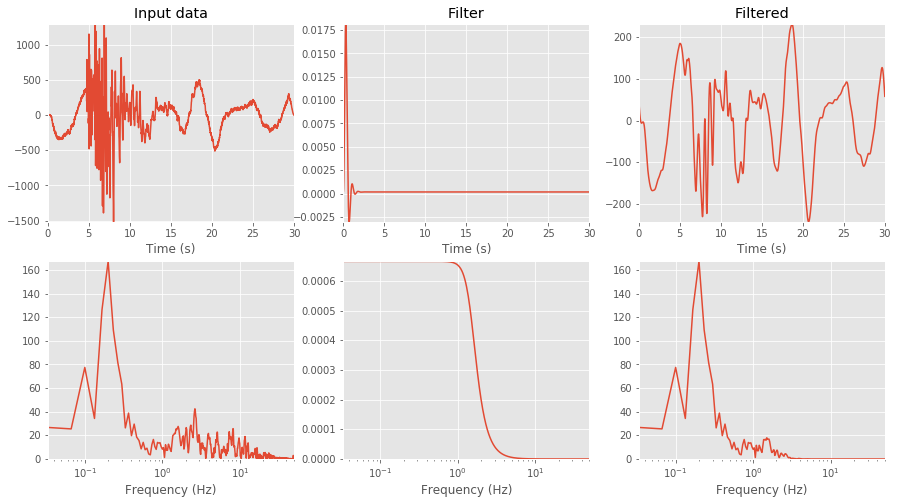

In [8]:
tr = read()[0]
tr = tr.detrend()  # Data must be de-trended before filtering

filt = design_filter(
    sample_rate=tr.stats.sampling_rate, data_length=tr.stats.npts,
    corners=[0.75], order=4, window_type="butter",
    filter_type="lowpass")
fig = filter_and_plot(tr.data, tr.stats.delta, filt=filt)

### Highpass filtering

High-pass filters **remove** low frequencies, and allow high frequencies to *pass-through*.

**Exercise:** Play with different window types, high passes and filter orders.

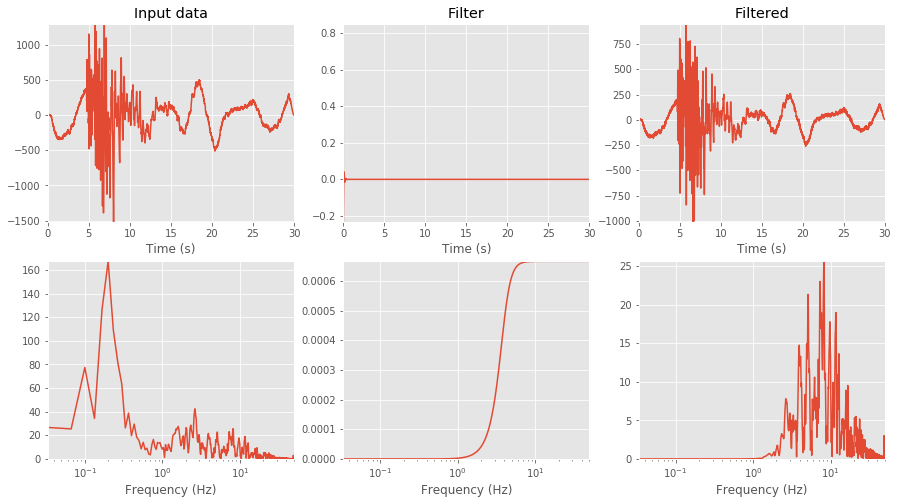

In [9]:
tr = read()[0]
tr = tr.detrend()  # Data must be de-trended before filtering

filt = design_filter(
    sample_rate=tr.stats.sampling_rate, data_length=tr.stats.npts,
    corners=[2.], order=4, window_type="butter",
    filter_type="highpass")
fig = filter_and_plot(tr.data, tr.stats.delta, filt=filt)

### Bandpass filtering

Bandpass filters allow a range of frequencies to pass through.  We commonly refer to the frequencies that are retained as
the *pass-band*.

**Exercise:** Play with different window types and low and high cuts. You can add more than two corners to make a more complex filter.

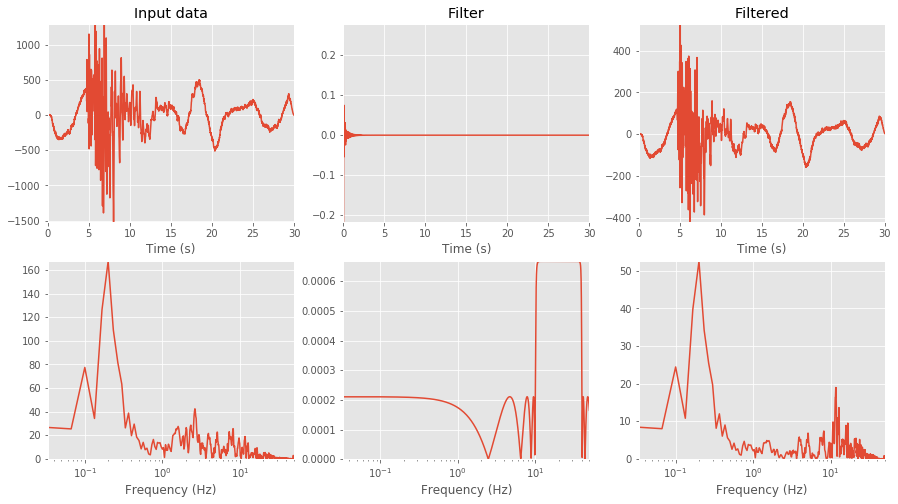

In [10]:
tr = read()[0]
tr = tr.detrend()  # Data must be de-trended before filtering

filt = design_filter(
    sample_rate=tr.stats.sampling_rate, data_length=tr.stats.npts,
    corners=[5., 20.], order=8, window_type="cheby2",
    filter_type="bandpass", attenuation=10)
fig = filter_and_plot(tr.data, tr.stats.delta, filt=filt)

## Causality

So far we have just looked at single-pass filters.  These output a causal waveform: there is
no signal before the real signal arrived, however peaks in the waveform might be shifted.
We have not been picky about the phase of our filters thus far, and there are an infinite number of possible causal filters for a single amplitude spectrum. Usually the minimum phase filter is
used, which concentrates energy at the front of the time series. The above filters were mixed
phase - energy was distributed throughout the time-series.

To avoid shifting peaks in the waveform we can use a **zero-phase** filter.  This zero-phase
filter is *acausal*: it is symmertical about the origin time and shifts some energy to occur
*before* the original signal. Note that this can result in apparently earlier arrivals,
you must be careful when applying filters prior to estimating seismic phase arrivals!
Zerophase filters can be acheived by running the same filter forwards then backwards.  This
has the effect of increasing the order of the final filter (e.g. a 2nd order filter becomes a
4th order filter). 

Below we demonstrate this using obspy filter method:

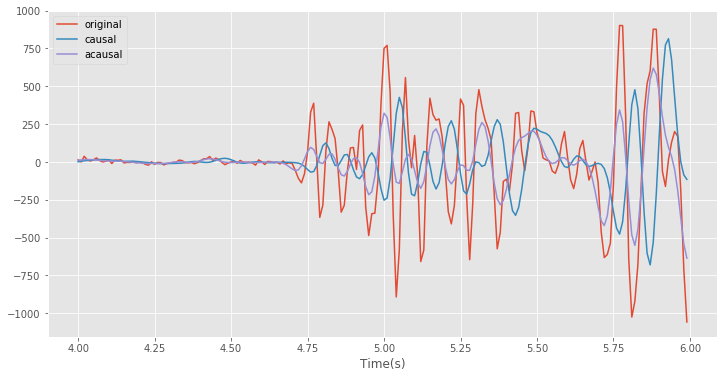

In [11]:
tr_highpass = tr.copy().filter("highpass", freq=1)  
# Remove background noise to simplify comparison
tr_acausal = tr_highpass.copy().filter(
    "lowpass", freq=10, corners=2, zerophase=True)
tr_causal = tr_highpass.copy().filter(
    "lowpass", freq=10, corners=4, zerophase=False)
plot_start, plot_end = (4.0, 6.0)

fig, ax = plt.subplots(figsize=(12, 6))
x_time = np.arange(0, tr.stats.npts * tr.stats.delta, tr.stats.delta)
plot_start_ind = int(plot_start * tr.stats.sampling_rate)
plot_end_ind = int(plot_end * tr.stats.sampling_rate)
trace_dict = {
    "original": tr_highpass,
    "causal": tr_causal,
    "acausal": tr_acausal}
for label, _tr in trace_dict.items():
    ax.plot(x_time[plot_start_ind: plot_end_ind], 
            _tr.data[plot_start_ind: plot_end_ind],
            label=label)
ax.legend()
_ = ax.set_xlabel("Time(s)")  # do not check returned value

If you focus on the first arrival you will note that the causal waveform only has energy after the original
waveform has energy, but the peaks are shifted.  In contrast, the acausal waveform has energy before
the original, but the peaks generally align with the original.

**Exercise:** Try changing the order of the above filters and see what happens.  The order of the filter affects the slope of the filter.  If the slope is too steep you may see ringing effects due to
Gibb's phenomenon.

## Poles and Zeros

Filters are often represented as *poles and zeros*. These are the roots of the denominator and
numerator of the transfer function resepectively. For example, if we have a filter defined by:
\begin{equation*}
    H(s) = \frac{s + 2}{s^2 + 0.25}
\end{equation*}
the zeros of this filter would be a single zero at $s=-2$, and the poles would be at 
$s=i\sqrt{0.25}, -i\sqrt{0.25}$.

Transfer functions for butterworth filters, one of the more commonly used filters in seismology
because it has no ripple (unlike the Chebychev filters), but can introduce time and phase shifts,
take the form:
\begin{equation*}
    G^2(\omega) = |H(i\omega)|^2 = \frac{G_0^2}{1 + \frac{i\omega}{i\omega_c}^{2n}}
\end{equation*}
where $\omega$ is the angular frequency, $\omega_c$ is the cut-off frequency (at half gain), $G$ is
gain, $G_0$ is the gain at DC ($\omega=0$ and $n$ is the order of the filter.  Note that the number
of poles is equal to $2n$.

Below is a demontration of increasing the order of a butterworth lowpass filter.  Note that the
slope increases with the order approaching a discontinuity.  The ideal filter would remove all
unwanted frequencies and retain all wanted frequencies without attenuation.  This would look
like a step in the frequency domain, however, such a discontinuity is unstable and results
in *ringing* also know as Gibb's phenomenon.

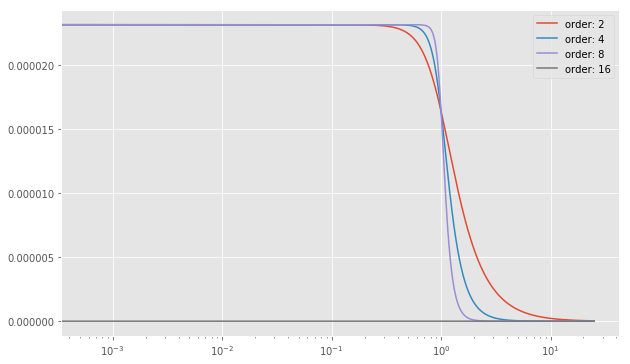

In [12]:
fig, ax = plt.subplots(figsize=(10, 6))
N = 86400
sample_rate = 50
dt = 1 / sample_rate
for order in [2, 4, 8, 16]:
    filt = design_filter(
        sample_rate=sample_rate, data_length=N,
        corners=[0.5], order=order, window_type="butter",
        filter_type="lowpass")
    x_freq = np.linspace(0.0, 1.0 / (2. * dt), int(N / 2))
    ax.semilogx(x_freq, 2./N * np.abs(filt[:N//2]),
                label="order: {0}".format(order))
_ = ax.legend()  # Do not check returned value

## Resampling

In a [previous notebook](2_Digitizers.ipynb) we covered naive decimation of data, however, there are
better/different ways to change the sampling rate of data.  We will explore two methods, the first
is frequency domain resampling, employed by obspy in the `.resample` method.  This effectively
re-maps the frequency spectra of your data onto a differently sampled frequency range.  This can
be used for either downsampling or upsampling data.  However, because it uses the FFT it is
susceptible to all the usual things associated with FFTs, most notable, Gibb's phenomenon.
The cell below contains a function to do this frequency domain resampling, the basic outline
of this function is:
1. Compute the (real) FFT of the data
2. Convolve the spectra with a hanning window (other windows are available)
    - This has the effect of stabalising discontinuities at the edge of the spectra
3. Re-map the spectra onto a new frequency range
    - Here we use the numpy `interp` function - if we were just decimating by an
      integer factor, we could just remove the spectra above the new Nyquist
4. Compute the inverse (real) FFT to get the newly resampled data.

In [13]:
def resample_and_plot(tr, sampling_rate):
    """
    Simplified (made less general) from obspy Trace.resample.
    
    Uses a frequency domain method to resample, and a hanning window.
    
    :type tr: `obspy.core.Trace`
    :param tr: Trace to resample
    :type sampling_rate: float
    :param sampling_rate: New sample rate for the trace
    """ 
    from scipy.signal import get_window
    from scipy.fftpack import rfft, irfft
    factor = tr.stats.sampling_rate / float(sampling_rate)
    
    # Copy things for plotting
    data_in = tr.data.copy()
    max_time = tr.stats.npts * tr.stats.delta
    dt = tr.stats.delta
    N = tr.stats.npts
    # resample in the frequency domain. Make sure the byteorder is native.
    x = rfft(tr.data.newbyteorder("="))
    # Cast the value to be inserted to the same dtype as the array to avoid
    # issues with numpy rule 'safe'.
    x = np.insert(x, 1, x.dtype.type(0))
    if tr.stats.npts % 2 == 0:
        x = np.append(x, [0])
    x_r = x[::2]
    x_i = x[1::2]

    # Multiply by a hanning window to stabilise the interpolation
    large_w = np.fft.ifftshift(
        get_window('hanning', tr.stats.npts))
    x_r *= large_w[:tr.stats.npts // 2 + 1]
    x_i *= large_w[:tr.stats.npts // 2 + 1]

    # interpolate
    num = int(tr.stats.npts / factor)
    df = 1.0 / (tr.stats.npts * tr.stats.delta)
    d_large_f = 1.0 / num * sampling_rate
    f = df * np.arange(0, tr.stats.npts // 2 + 1, dtype=np.int32)
    n_large_f = num // 2 + 1
    large_f = d_large_f * np.arange(0, n_large_f, dtype=np.int32)
    large_y = np.zeros((2 * n_large_f))
    large_y[::2] = np.interp(large_f, f, x_r)
    large_y[1::2] = np.interp(large_f, f, x_i)

    large_y = np.delete(large_y, 1)
    if num % 2 == 0:
        large_y = np.delete(large_y, -1)
    tr.data = irfft(large_y) * (float(num) / float(tr.stats.npts))
    tr.stats.sampling_rate = sampling_rate
    
    # Plot
    fig, axes = plt.subplots(ncols=2, figsize=(14, 6))
    axes[0].plot(np.arange(0, max_time, dt), data_in)
    axes[1].semilogx(
        np.linspace(0.0, 1.0 / (2. * dt), int(N / 2)),
        2./N * np.abs(x[:N//2]), label="Original")
    axes[1].semilogx(
        np.linspace(dt, dt + 1.0 / (2. * tr.stats.delta), num // 2),
        2./N * np.abs(large_y[:num//2]), label="Resampled")
    axes[0].plot(np.arange(0, max_time, 1 / sampling_rate), tr.data)
    axes[1].legend()
    axes[0].set_xlabel("Time (s)")
    axes[1].set_xlabel("Frequency (Hz)")
    return tr

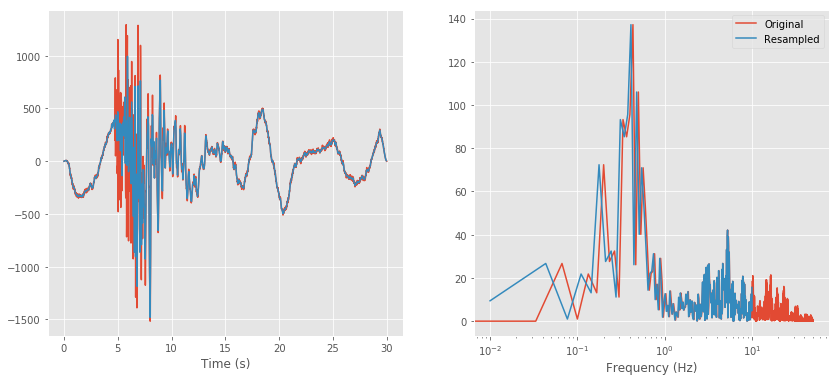

In [14]:
tr_resampled = resample_and_plot(tr.copy(), 20)

The plots generated show the original data overlain with the resampled data.  You will note that the low frequencies are mostly maintained in the time-series, but we lose high-frequency energy.  In the spectra plots the resampled spectra looks very similar to the original spectra up to the newly
selected Nyquist, where the resampled spectra stops.  There is a slight shift between the spectra,
which shows up as misallignment at low frequencies (note this shift is throughout the spectra, but
the log scale makes it more obvious at low frequencies).  This shift is not real and arrises
due to the original spectra being padded with an adidtional zero at the start.

**Exercise:** Try different sampling frequencies. 
What do the data look like when you over-sample them?
What about when you drop down to 1.5 Hz?

### Upsampling - sinc resampling

Often in earthquake seismology we want to reduce the sampling rate after recording (remembering that
even if we later increase the sampling rate we will not be able to capture additional energy above
the Nyquist frequency).  However, sometimes we need data at high sampling rates.  Resampling in
the frequency domain allows us to do this, but often does not accurately capture the peak amplitudes
of the data.  

One of the better methods of doing this kind of upsampling is to use sinc interpolation.  The sinc
function:
\begin{equation*}
    \operatorname{sinc}(x) = \frac{\sin(x)}{x}
\end{equation*}
is the theoretical optimum reconstruction filter for band-limited signals - it is the closest
periodic function to a delta (spike):

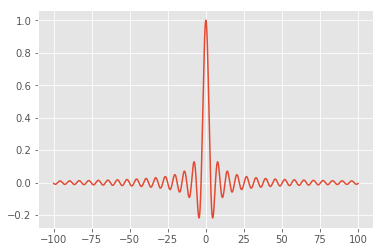

In [15]:
x = np.arange(-100, 100, 0.01)
y = np.sin(x) / x
line = plt.plot(x, y)

If we add multiple sinc functions together we can start to construct box-car functions (functions that are zero-valued everywhere except in a range where the function is equal to some 
non-zero value).  This happens because we can align the functions such that deconstuctive 
interferance happens everywhere apart from at the peak of the function:

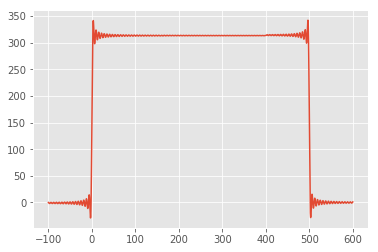

In [16]:
x = np.arange(-100, 600, 0.01)
y = np.zeros_like(x)
sinc = np.sin(x) / x
y += sinc
for shift_no in range(1, 50000):
    y[shift_no:] += sinc[0:-shift_no]
line = plt.plot(x, y)

We can make use of the sinc function to interpolate seismic data.  For finite data we cannot use a
true sinc function, but we can use Lanczos resampling, which is supported by obspy.  Below is a
demonstration of how frequency domain resampling reduces the amplitude of peaks in data, but
Lanczos does a good job of matching the original data.

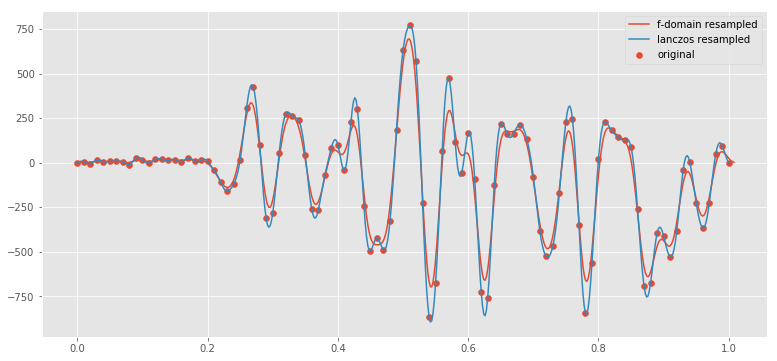

In [17]:
new_rate = 500

tr_trimmed = tr.copy().trim(
    tr.stats.starttime + 4.5, tr.stats.starttime + 5.5).detrend()
tr_resampled = tr_trimmed.copy().resample(new_rate)
tr_lanczos = tr_trimmed.copy().interpolate(
    new_rate, method="lanczos", a=20)

fig, ax = plt.subplots(1, figsize=(13, 6))
ax.scatter(
    np.arange(0, tr_trimmed.stats.npts * tr_trimmed.stats.delta,
              tr_trimmed.stats.delta),
    tr_trimmed.data, label="original")
ax.plot(
    np.arange(0, tr_resampled.stats.npts * tr_resampled.stats.delta,
              tr_resampled.stats.delta),
    tr_resampled.data, label="f-domain resampled")
ax.plot(
    np.arange(0, tr_lanczos.stats.npts * tr_lanczos.stats.delta,
              tr_lanczos.stats.delta),
    tr_lanczos.data, label="lanczos resampled")
_ = ax.legend()

## Conclusion

That concludes our look into filtering and resampling.  The ideas behind frequency domain operations
are often hiden in seismic software, so it is important to understand what you are doing to your
data: the filtering that you perform can increase signal-to-noise ratio, but you have to be careful
that you are not destroying or altering something that you care about (e.g. time or amplitude).

The final notebook in this module provides an [introduction to obspy](5_Intro_To_Obspy.ipynb).
We will use Obspy extensively in future notebooks because a lot of convenience functions are included
there.  This means that, now that we understand the fundamentals of how these things work, we can
focus on other things!